# Identifying the Authors of Classic English Fiction Books

Given an exerpt from an English text, we hope to create a classifcation model that will be able to identify the probability that the work was writtne by a particular author. Our model will use stylometric features (quantifiable features that capture some element of a work's style) to classify and assign works to differnt authors. The candidate authors are Charles Dickens, Jane Austen, Mark Twain, etc.

Given a text in English, we wish to perform a classification in predicting what author among several possible candidates wrote it. The writing styles of any two authors generally differs, and we hope to build a model that recognizes this difference in a consistent way. 
...label chunks of texts to one out of several possible candidate authors. The candidate authors are Charles Dickens, Jane Austen, Mark Twain (add more).


# Imports 

The next cell contains libraries that need to be installed before data retrieval. In addition, NLTK's ngrams may require NLTK's data package. To download run python3 and the following commands:

import nltk <br>
nltk.download()

In [2]:
import pandas as pd
import os
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer, sent_tokenize
import numpy as np
import matplotlib.pyplot as plt



# Feature extraction 

<b>Lexical features</b> <br>
   1) character specific features<br>
   2) word specific features<br>
   3) n-grams <br>
   4) word richness <br><br>
<b>Syntactic features</b> <br>
   1) punctuation << <br>
   2) function words << <br>
   3) part of speech <br><br>
<b>Structural features</b> <br>
   1) average length of words <br>
   2) average length of sentences <br>
   3) # of sentences <<  <br>

We are working on the features that are <<. There are many features to consider, but we are still discussing which features we are using in the model. 

# Book Frequency
The number of books we have for each author we are considering to classify.

In [4]:
path = "../data/texts_cleaned/"
authors = []
book_counts = []
for author in os.listdir(path):
    if author != ".DS_Store":
        book_counts.append(len(os.listdir(path + author)))
        authors.append(author)

In [5]:
books_freq = pd.DataFrame( book_counts, index=authors, columns = ["Frequency"] )
books_freq

,Frequency
edgar_rice_burroughs,24
robert_louis_stevenson,42
thomas_hardy,26
jack_london,50
oscar_wilde,23
lewis_carroll,10
george_macdonald,61
mildred_a._wirt,24
mark_twain,28
elizabeth_gaskell,21


Text(0,0.5,'Number of Books')

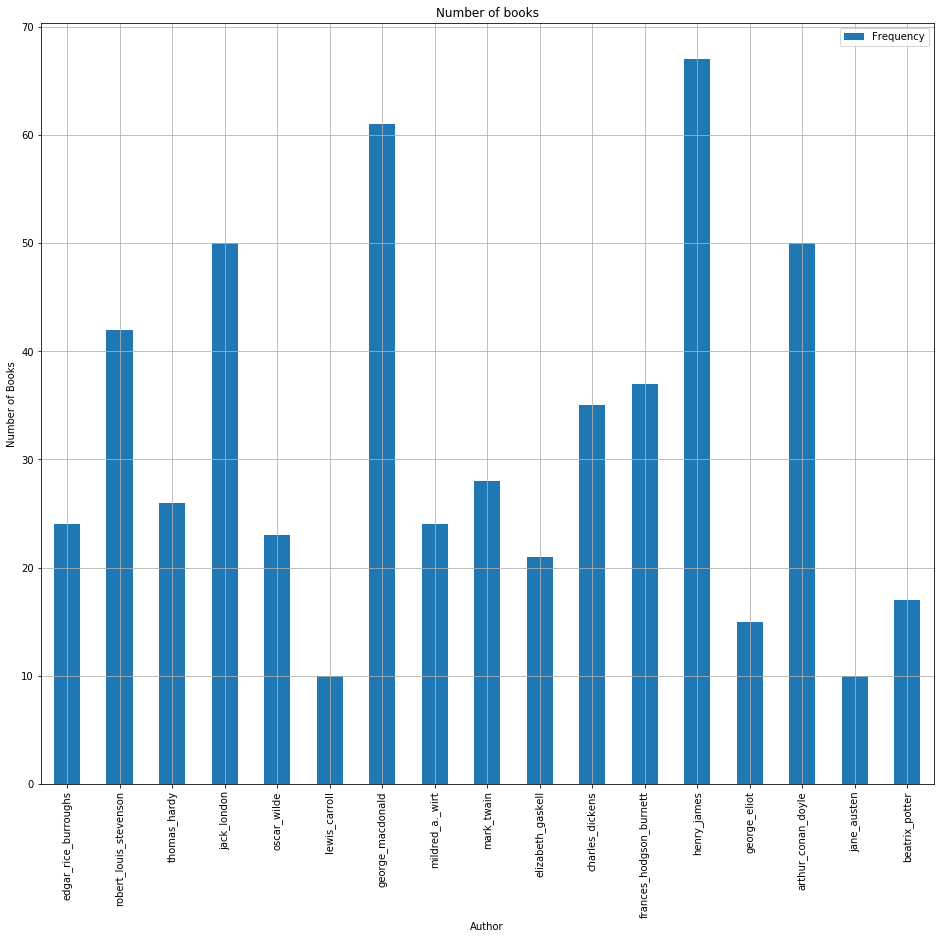

In [6]:
ax = books_freq.plot(kind='bar', figsize=(16,14), title='Number of books', grid=True)
ax.set_xlabel("Author")
ax.set_ylabel("Number of Books")

In [7]:
books_freq.describe()

,Frequency
count,17.000000
mean,31.764706
std,17.159288
min,10.000000
25%,21.000000
50%,26.000000
75%,42.000000
max,67.000000


The range of frequencies is 52 book. 

In [8]:
path_to_authors = "../data/texts_cleaned/"
author_list = os.listdir(path_to_authors)

author_books_table = pd.DataFrame(index = author_list, columns = ["Number of Books", "Total Data"])


for author in author_list:
    size = 0
    books = os.listdir(path_to_authors + author)
    number_of_books = len(books)
    for book in books:
        size += os.path.getsize(path_to_authors + author + "/" + book)
    author_books_table.at[author, "Number of Books"] = number_of_books
    author_books_table.at[author, "Total Data"] = size

author_books_table 

,Number of Books,Total Data
edgar_rice_burroughs,24,8900397
robert_louis_stevenson,42,12937901
thomas_hardy,26,13175284
jack_london,50,16485779
oscar_wilde,23,3578554
lewis_carroll,10,1355847
george_macdonald,61,30621767
mildred_a._wirt,24,5330851
mark_twain,28,12272690
elizabeth_gaskell,21,9239624


Text(0.5,0,'Authors')

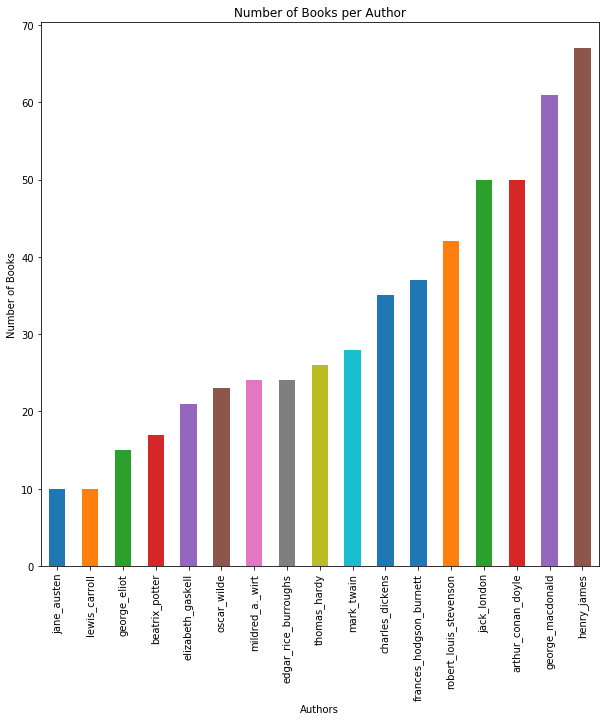

In [27]:
p = author_books_table["Number of Books"].sort_values().plot.bar(figsize=(10,10), title="Number of Books per Author")
p.set_ylabel("Number of Books")
p.set_xlabel("Authors")

Text(0.5,0,'Authors')

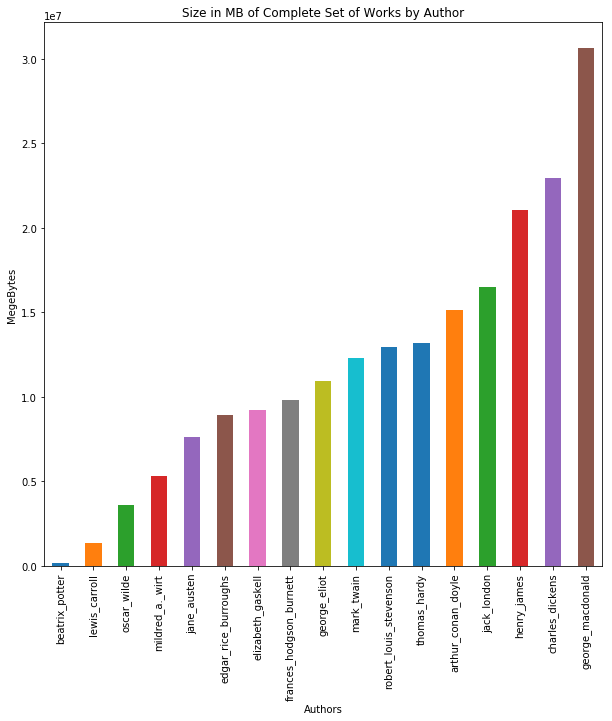

In [26]:
pl = author_books_table["Total Data"].sort_values().plot.bar(figsize=(10,10), title="Size in MB of Complete Set of Works by Author")
pl.set_ylabel("MegeBytes")
pl.set_xlabel("Authors")

# Word Length Distributions

The following cell contains a class that extracts the features we are looking for. The "self.build_row" line will extract all the features of a book if it is uncommented.

In [7]:
class Text():

    def __init__(self, text):
        self.text = text.lower()
        self.tokens = TweetTokenizer().tokenize(self.text)
        self.sentences = sent_tokenize(self.text)
        self.total_number_of_tokens = len(self.tokens)
        self.row = {}
        #self.build_row()

    def build_row(self):
        self.word_gram_data()
        self.pos_data()
        self.word_richness()
        self.word_length_data()
        self.sentence_length_data()


    def word_gram_data(self):
        output_dictionary = {}
        for n in range(1, self.max_ngrams + 1):
            n_grams = ngrams(self.tokens, n)
            all_grams = list(n_grams)
            total = len(all_grams)
            grams_collection = collections.Counter(all_grams)
            grams_collection = dict(grams_collection)

            for ngram, count in grams_collection.items():
                output_dictionary[" ".join(ngram)] = count/total

        return output_dictionary
    
    def count_map(self, items):
        count_map = {}
        for item in items:
            if item in count_map:
                count_map[item] += 1
            else:
                count_map[item] = 1
        return count_map

    def percentage_map(self, count_map, total):
        return( { key : (lambda count: count / total)(count) for ( key, count ) in count_map.items() } )


    def pos_gram_data(self):
        output_dictionary = {}
        pos_tags = nltk.pos_tag(self.tokens)
        pos_tags = [pos[1] for pos in pos_tags]

        for n in range(1, self.max_ngrams + 1):
            n_grams = ngrams(pos_tags, n)
            all_grams = list(n_grams)
            total = len(all_grams)
            grams_collection = collections.Counter(all_grams)
            grams_collection = dict(grams_collection)

            for ngram, count in grams_collection.items():
                output_dictionary[" ".join(ngram)] = count/total

        return output_dictionary

    def word_lengths(self):
        word_lengths = []
        forbidden = [".", ",", "?", "!", "\"","\'",";",":"]
        for word in self.tokens:
            if word not in forbidden:
                word_lengths.append(len(word))
        return sorted(word_lengths)

    def sentence_lengths(self):
        sentence_lengths = []
        for sentence in self.sentences:
            sentence_lengths.append(len(sentence.split(" ")))
        return sorted(sentence_lengths)

    def word_length_distr(self):
        word_lengths = self.word_lengths()
        return self.percentage_map( self.count_map(word_lengths), len(word_lengths) ) 

    def sentence_lengths_distr(self):
        sentence_lengths = self.sentence_lengths()
        return percentage_map( count_map(sentence_lengths), len(sentence_lengths) )

    def word_length_data(self):
        word_lengths = self.word_lengths()
        self.row.update( {'word_length_avg': np.mean(word_lengths),'word_length_std_dev': np.std(word_lengths)} )

    def sentence_length_data(self):
        sentence_lengths = self.sentence_lengths()
        self.row.update( {'sentence_length_avg': np.mean(sentence_lengths), 'sentence_length_std_dev': np.std(sentence_lengths) })

    def word_richness(self):
        self.row.update( {'word_richness': len(self.tokens) / len(set(self.tokens)) } )
        


<b>George Eliot's books</b>

In [8]:
author = "george_eliot"
path = "./data/texts_cleaned/" + author
books = os.listdir(path)

word_len_dis = {}
books_df = pd.DataFrame()
for i in range(0, len(books)):
    text = Text(open(path + "/" + books[i],'r').read())
    text.word_length_data()
    text.sentence_length_data()
    word_len_dis[books[i]]= text.word_length_distr()
    book_df = pd.DataFrame(text.row,index =[books[i]])
    books_df = books_df.append(book_df)
books_df

,sentence_length_avg,sentence_length_std_dev,word_length_avg,word_length_std_dev
adam_bede.txt,22.578768,17.081693,4.214905,2.250040
brother_jacob.txt,26.129032,20.096634,4.474994,2.527334
daniel_deronda.txt,20.157440,16.809473,4.440357,2.520916
"felix_holt,_the_radical.txt",20.851522,16.674801,4.418443,2.480119
"george_eliot's_life,_vol._i_(of_3).txt",22.427593,22.924453,4.437861,2.730468
"george_eliot's_life,_vol._ii_(of_3).txt",20.502062,26.850314,4.415402,2.721390
"george_eliot's_life,_vol._iii_(of_3).txt",20.254713,21.176592,4.396395,2.695095
how_lisa_loved_the_king.txt,36.040323,22.455116,4.358461,2.094614
impressions_of_theophrastus_such.txt,36.536519,25.984431,4.745520,2.807803
middlemarch.txt,19.888934,15.804937,4.426622,2.511229


In [8]:
books_df.describe()

,sentence_length_avg,sentence_length_std_dev,word_length_avg,word_length_std_dev
count,15.000000,15.000000,15.000000,15.000000
mean,24.980305,20.145695,4.432818,2.528001
std,5.731209,3.562981,0.135074,0.202137
min,19.895432,15.808332,4.214895,2.109396
25%,20.752616,17.190443,4.365180,2.420600
50%,22.461383,18.915644,4.427191,2.522205
75%,26.553719,22.697348,4.457832,2.713001
max,36.537201,26.889104,4.745950,2.808715


The standard deviations for sentence length's avg (5.73) and std_dev(3.56) is greater than standard deviation for word length's avg (0.135) and std_dev (0.202). Thus showing that the word length were very consistent in all Eliot's books. 

Text(0.5,0,'sentence_length_avg')

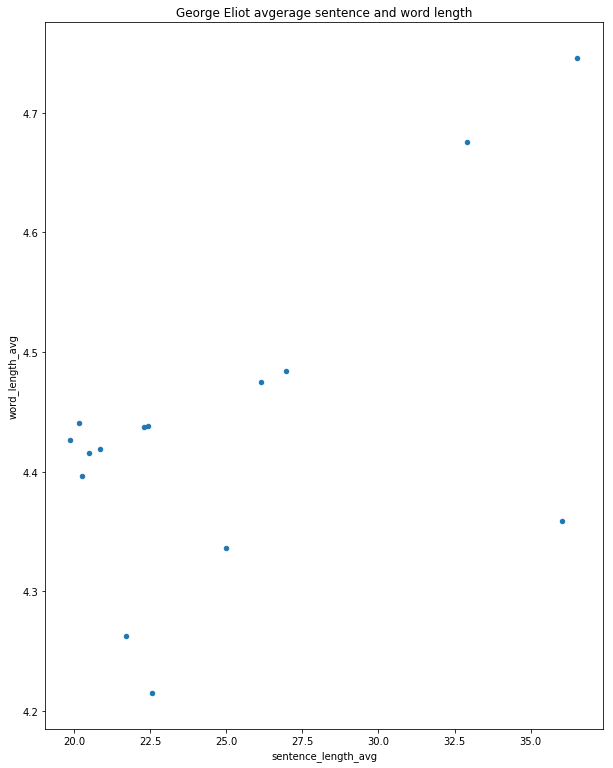

In [9]:
ax = books_df.plot.scatter(x="sentence_length_avg", y="word_length_avg",figsize=(10,13), title='George Eliot avgerage sentence and word length')
ax.set_ylabel("word_length_avg")
ax.set_xlabel("sentence_length_avg")

In [10]:
books_df["sentence_length_avg"].corr(books_df["word_length_avg"])

0.5515770598663263

There is a medium correlation between average sentence and word length in George Eliot's books. This shows that Eliot's sentence lengths were partially consistent with the word lengths in her books.   

The line graph below shows the word length distribution each of Eliot's books. 

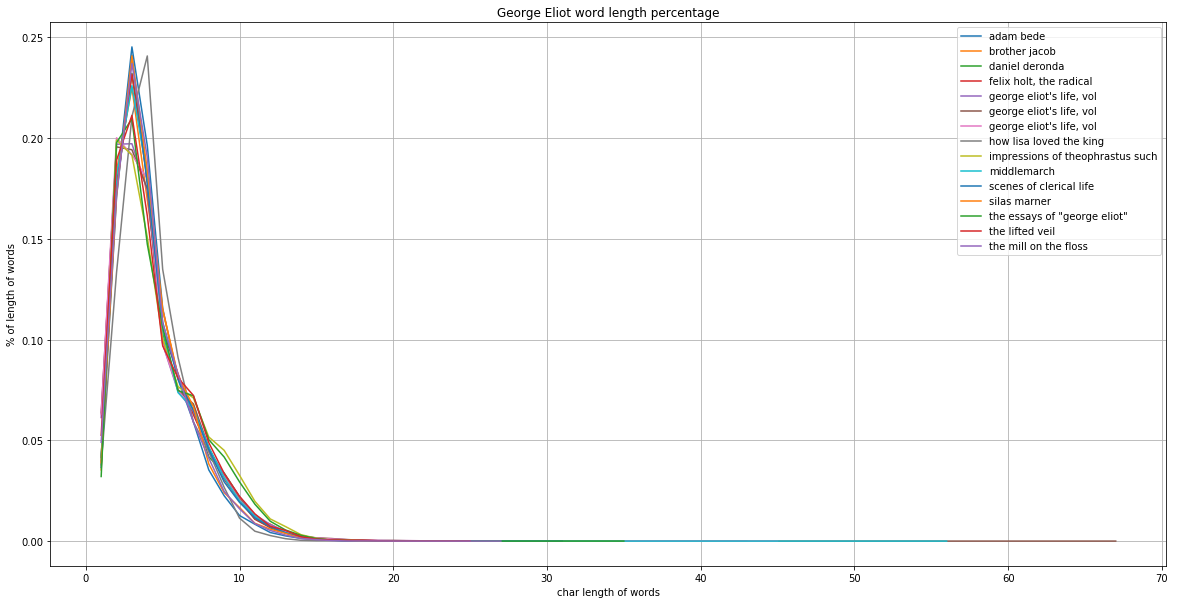

In [10]:
plt.figure(figsize=(20,10))

for book in word_len_dis.keys():
    label = book.split(".")[0]
    label = label.replace("_", " ")
    plt.plot(  word_len_dis[book].keys(), word_len_dis[book].values(), label= label)

plt.xlabel('char length of words')
plt.ylabel('% of length of words')
plt.title( 'George Eliot word length percentage' )
plt.grid(True)
plt.legend()
plt.show()

Each of Eliot's books display a similar postively skewed distribution. This further supports that all of Eliot's books have consistent word lengths. 


<b>Elizabeth Gaskell's books</b>

In [11]:
author = "elizabeth_gaskell"
path = "./data/texts_cleaned/" + author
books = os.listdir(path)

word_len_dis = {}
books_df = pd.DataFrame()
for i in range(0, len(books)):
    text = Text(open(path + "/" + books[i],'r').read())
    text.word_length_data()
    text.sentence_length_data()
    word_len_dis[books[i]]= text.word_length_distr()
    book_df = pd.DataFrame(text.row,index =[books[i]])
    books_df = books_df.append(book_df)
books_df

,sentence_length_avg,sentence_length_std_dev,word_length_avg,word_length_std_dev
a_dark_night's_work.txt,21.128847,18.435456,4.327923,2.369145
an_accursed_race.txt,27.897674,17.912156,4.556359,2.457672
cranford.txt,28.952025,23.537146,4.099586,2.350665
"curious,_if_true.txt",23.223604,19.180071,4.256231,2.306718
half_a_life-time_ago.txt,20.489388,15.814632,4.094107,2.259172
lizzie_leigh.txt,16.128552,13.440934,4.121014,2.085431
mary_barton.txt,17.452276,15.752652,4.173311,2.207385
my_lady_ludlow.txt,22.793550,19.404705,4.170467,2.309228
north_and_south.txt,16.034782,14.681083,4.220793,2.318979
round_the_sofa.txt,37.281553,28.938977,4.131799,2.360520


In [12]:
books_df.describe()

,sentence_length_avg,sentence_length_std_dev,word_length_avg,word_length_std_dev
count,21.000000,21.000000,21.000000,21.000000
mean,22.251473,18.039783,4.223541,2.298967
std,5.125773,3.451870,0.115615,0.102971
min,15.066485,13.131285,4.087495,2.085431
25%,18.435894,15.814632,4.141324,2.251497
50%,21.847050,18.407136,4.220793,2.309228
75%,24.005025,19.048183,4.254043,2.350665
max,37.281553,28.938977,4.556359,2.553111


The standard deviations for sentence length's avg (5.12) and std_dev(3.42) is greater than standard deviation for word length's avg (0.124) and std_dev (0.101). Thus showing that the word length were very consistent in all Gaskell's books. 

Text(0.5,0,'sentence_length_avg')

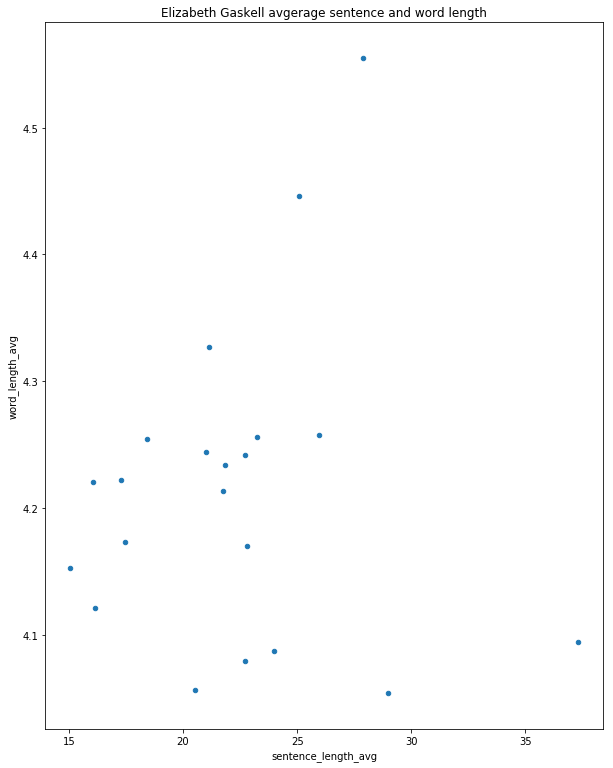

In [14]:
ax = books_df.plot.scatter(x="sentence_length_avg", y="word_length_avg",figsize=(10,13), title='Elizabeth Gaskell avgerage sentence and word length')
ax.set_ylabel("word_length_avg")
ax.set_xlabel("sentence_length_avg")

In [15]:
books_df["sentence_length_avg"].corr(books_df["word_length_avg"])

0.05360175637494839

There is a low correlation between average sentence and word length in Elizabeth Gaskell's books. This shows that Gaskell's sentence lengths were not consistent with the word lengths in her books.   

The line graph below shows the word length distribution each of Gaskell's books. 

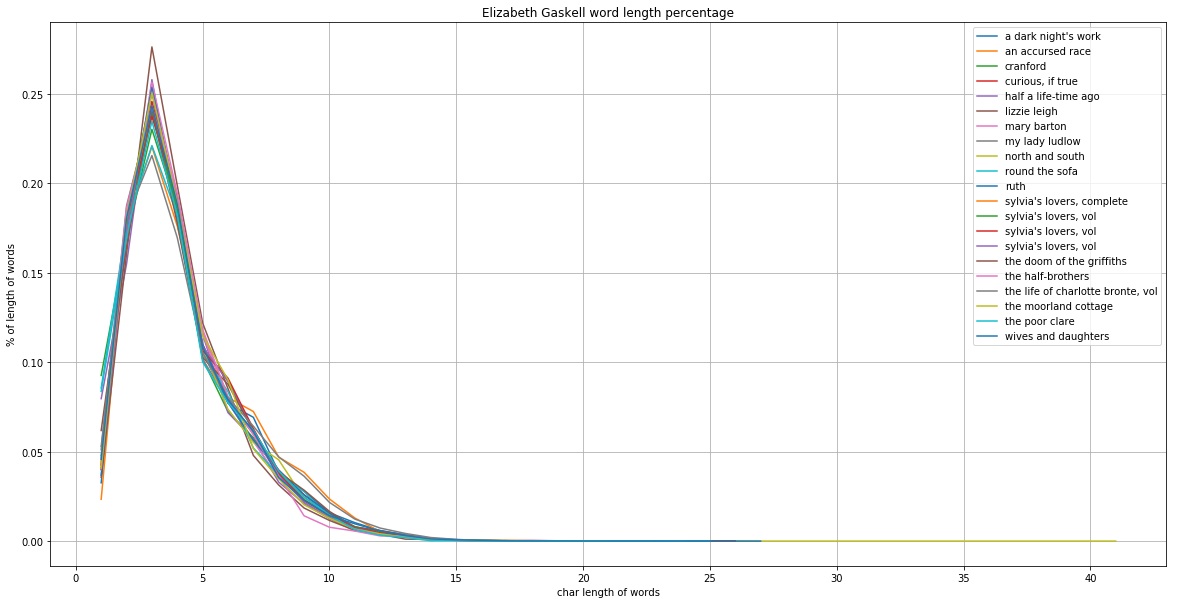

In [16]:
plt.figure(figsize=(20,10))

for book in word_len_dis.keys():
    label = book.split(".")[0]
    label = label.replace("_", " ")
    plt.plot(  word_len_dis[book].keys(), word_len_dis[book].values(), label= label)

plt.xlabel('char length of words')
plt.ylabel('% of length of words')
plt.title( 'Elizabeth Gaskell word length percentage' )
plt.grid(True)
plt.legend()
plt.show()

Each of Gaskell's books display a similar postively skewed distribution. This further supports that all of her books have consistent word lengths. 
